### Example notebook - OMICS correlation: gene to gene

This notebook demonstrates reading from API and performing analysis of OMICS data correlation.
- title: "OMICS correlation: gene to gene"
- author: "Margaret Paiva"
- date: "25/10/2021"
- output: R notebook

### 1. Dependencies

In [34]:
# cran packages
x <- c('jsonlite',
       'rjson',
       'httr',   
       'dplyr', 
       'data.table',  
       'tidyr', 
       'tibble', 
       'reshape2',
       'ggplot2')

In [35]:
# install cran packages
for (pkg in x) {
    if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
}

In [36]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(x, load_lib))

### 2. Request data from API
Request data from API using the files at https://github.com/Champions-Oncology/Workspaces/tree/main/1starter_data_request.

This notebook used the following options to request data:

- table="expression",
- cancer_type=["all"],
- genes=["ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", "RB1", "CHEK2", "APOBEC3B", "PALB2"],
- source = "PDX"

(For example, if you use the data_request.ipynb in Python, these are the options in the df, location = request_data() function.)

### 3. Read data

In [37]:
# change to where you saved your .csv file and file name
df  <- fread("../data/pdx_expression_few_genes_all_cancers.csv")  
df$gene  <- as.character(df$gene)
df$log.tpm  <- as.numeric(df$log.tpm)
head(df, 2)
print(dim(df))

gene,model,model_name,log.tpm,z,fold,tumor_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
BRCA1,CTG-2829,CTG-2829,3.081518,-1.123824,0.7514598,Breast
PALB2,CTG-2829,CTG-2829,5.353008,3.287629,1.5171099,Breast


[1] 20640     7


In [38]:
# Extract the expression values and pivot a table for genes
gene_tpm <- df %>% 
  dplyr::select(gene, log.tpm, model) %>% 
  na.omit() %>% 
  pivot_wider(names_from = gene, 
              values_from = log.tpm) %>% 
  column_to_rownames('model')
gene_tpm[1:5, 1:5]

,BRCA1,PALB2,CCND1,CDKN1B,KRAS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CTG-2829,3.081518,5.353008,6.612856,6.256398,3.587479
CTG-0437,3.618647,3.687081,4.885116,5.735280,5.146602
CTG-0093,3.602469,3.144759,6.614539,5.466478,5.730350
CTG-2535,3.690036,4.030954,3.899270,6.115044,3.533881
CTG-0664,4.185268,4.575462,4.908090,4.991020,4.077113


### 4. Example to correlate two genes
If you plan to run the code in the following two cells, please make sure that the genes you select exist in the gene_tpm table. 

In [1]:
# # The correlation
# rho <- cor(gene_tpm$BRCA1, 
#            gene_tpm$BRCA2) # put your genes of interest here (they must exist in the colnames of gene_tpm)
# rho

In [2]:
# # Plotting
# options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=180) # figure size here
# ggplot(gene_tpm, mapping = aes(x = BRCA1, y = BRCA2))+ # same genes of interest here
# geom_point()+
# geom_smooth(method = "lm", se = FALSE, formula = y ~ x)+
# geom_text(x = 1.6, y = 6, label = paste("Correlation=", round(rho, 3), collapse=""))+
# ggtitle("Correlation of the log.tpm from two genes")+
# xlab("BRCA1")+
# ylab("BRCA2")

### 5. Correlation map of all requested genes

In [41]:
# Correlation matrix
cormat <- round(cor(gene_tpm, method = 'spearman',
                    use = 'na.or.complete'), 1)
cormat[1:5, 1:5]

,BRCA1,PALB2,CCND1,CDKN1B,KRAS
BRCA1,1.0,0.4,-0.1,0.2,0.2
PALB2,0.4,1.0,0.0,0.2,0.2
CCND1,-0.1,0.0,1.0,0.1,0.1
CDKN1B,0.2,0.2,0.1,1.0,0.3
KRAS,0.2,0.2,0.1,0.3,1.0


In [42]:
# We do not need the whole matrix because the correlation between gene A and B
# is the same as the correlation between gene B and A
# Therefore, use the following function to extract half of the matrix
get_lower_tri<-function(cormat){
    cormat[upper.tri(cormat)] <- NA  # the upper triangle is filled with NA
    return(cormat)}

In [43]:
# a triangle portion of the matrix
lower_tri <- get_lower_tri(cormat)
lower_tri[1:5, 1:5]  
# now the upper triangle is filled with NA since they are the repeats of the lower triangle

,BRCA1,PALB2,CCND1,CDKN1B,KRAS
BRCA1,1.0,NA,NA,NA,NA
PALB2,0.4,1.0,NA,NA,NA
CCND1,-0.1,0.0,1.0,NA,NA
CDKN1B,0.2,0.2,0.1,1.0,NA
KRAS,0.2,0.2,0.1,0.3,1


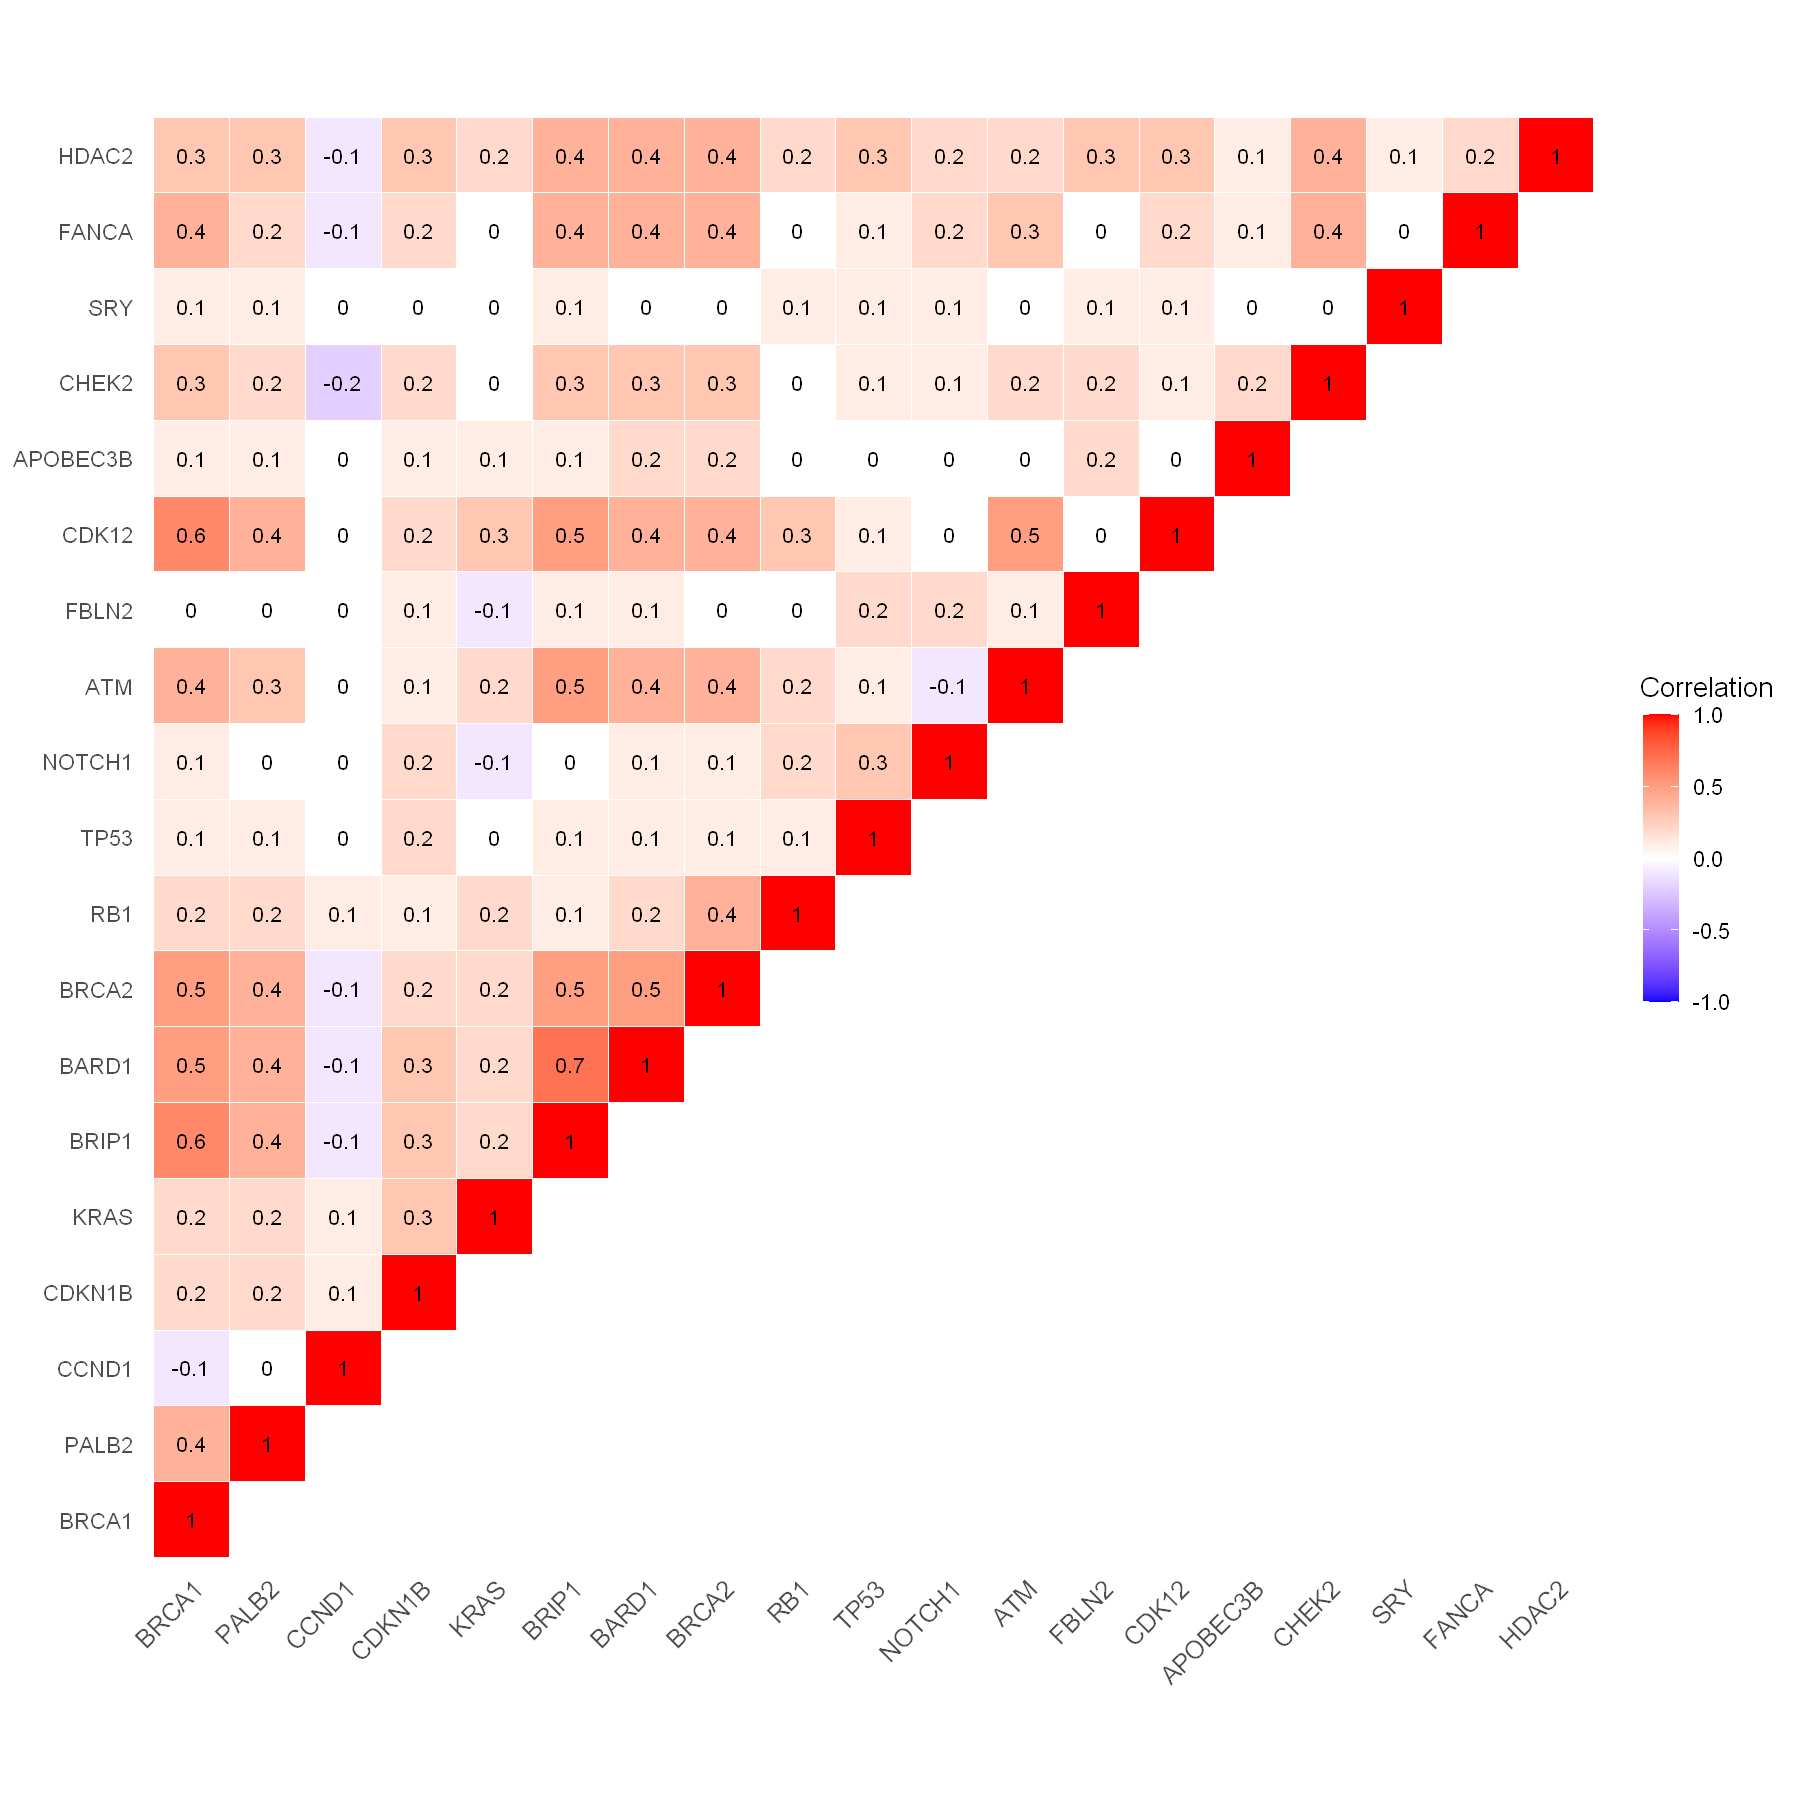

In [44]:
# first, format the matrix for plotting
melted_cormat <- melt(lower_tri, na.rm = TRUE)

# plotting
options(repr.plot.width=10, repr.plot.height=10, repr.plot.res=180)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 10, hjust = 1))+
 coord_fixed()+
 geom_text(aes(Var2, Var1, label = value), color = "black", size = 3)+
 theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank())+
  guides(fill = guide_colorbar(barwidth = 1, barheight = 8,
                title.position = "top", title.hjust = 0.5))